Data preparation and analysis

In [1]:
import pandas as pd
from datasets import load_dataset
data = load_dataset('emotion')

/Users/jj/Desktop/emotion_recognition/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [3]:
data.set_format(type='pandas')
df = data['train'][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


In [4]:
# six emotion classes: sadness, joy, love, anger, fear, surprise
classes = data['train'].features['label'].names
classes

['sadness', 'joy', 'love', 'anger', 'fear', 'surprise']

In [5]:
# add label classes to df
df['label_name'] = df['label'].apply(lambda x: classes[x])
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


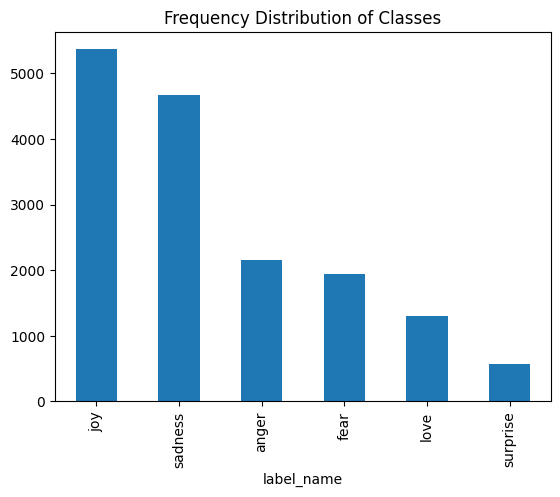

In [6]:
# emotion distribution
import matplotlib.pyplot as plt
label_counts = df['label_name'].value_counts()
label_counts.plot.bar()
plt.title('Frequency Distribution of Classes')
plt.show()

<Axes: title={'center': 'text_length'}, xlabel='label_name'>

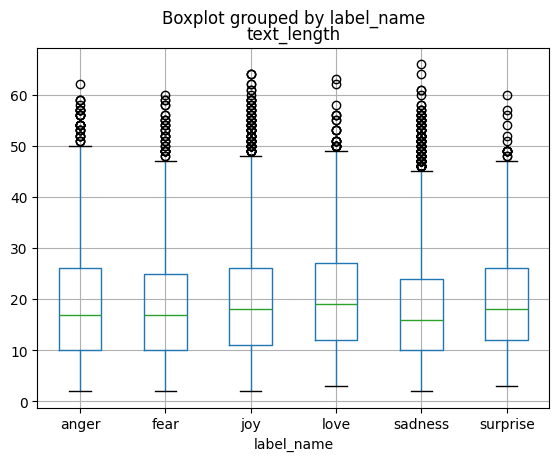

In [7]:
# length distribution of the text tweet
df['text_length'] = df['text'].str.split().apply(len)
df.boxplot(column='text_length', by='label_name')

Model Building & Training

In [8]:
from transformers import AutoTokenizer
import torch
model = "huawei-noah/TinyBERT_General_4L_312D" # change into different bigger models
tokenizer = AutoTokenizer.from_pretrained(model, use_fast=True)

In [9]:
# Tokenization of the emotion data
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True, max_length=300)
    return temp

In [10]:
# preprocess the data for the model training
# data.reset_format()
data = load_dataset('emotion')
data_encoded = data.map(tokenize, batched=True, batch_size=None)

Map: 100%|██████████| 2000/2000 [00:00<00:00, 47719.21 examples/s]


In [11]:
data_encoded

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 2000
    })
})

In [12]:
num_labels = len(classes)
label2id, id2label = dict(), dict()
for i, label in enumerate(classes):
    label2id[label] = i
    id2label[i] = label

print(label2id)
print(id2label)

{'sadness': 0, 'joy': 1, 'love': 2, 'anger': 3, 'fear': 4, 'surprise': 5}
{0: 'sadness', 1: 'joy', 2: 'love', 3: 'anger', 4: 'fear', 5: 'surprise'}


In [13]:
# model evaluation function
import evaluate
import numpy as np

accuracy = evaluate.load('accuracy')

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1) # row-wise comparison
    return accuracy.compute(predictions=predictions, references=labels)

In [14]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer
import torch 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_ckpt = AutoModelForSequenceClassification.from_pretrained(model, num_labels=num_labels, label2id=label2id, id2label=id2label).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at huawei-noah/TinyBERT_General_4L_312D and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [15]:
args = TrainingArguments(
    output_dir='ft_tinybert_dir', 
    overwrite_output_dir = True,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    eval_strategy='epoch',
    save_strategy='epoch',
)

trainer = Trainer(
    model=model_ckpt,
    args=args,
    train_dataset=data_encoded['train'],
    eval_dataset=data_encoded['test'],
    compute_metrics=compute_metrics,
    tokenizer=tokenizer
)


/var/folders/78/dz_kq5nn1vn_cw3v1nflhf980000gn/T/ipykernel_2024/850957989.py:12: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [16]:
trainer.train()

/Users/jj/Desktop/emotion_recognition/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


Epoch,Training Loss,Validation Loss,Accuracy
1,0.858200,0.672335,0.810000
2,0.479900,0.406085,0.884000
3,0.379300,0.363763,0.894000


/Users/jj/Desktop/emotion_recognition/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)
/Users/jj/Desktop/emotion_recognition/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


TrainOutput(global_step=3000, training_loss=0.6681883188883464, metrics={'train_runtime': 144.6506, 'train_samples_per_second': 331.834, 'train_steps_per_second': 20.74, 'total_flos': 116983808064000.0, 'train_loss': 0.6681883188883464, 'epoch': 3.0})

In [17]:
trainer.evaluate()

/Users/jj/Desktop/emotion_recognition/.venv/lib/python3.11/site-packages/torch/utils/data/dataloader.py:683: UserWarning: 'pin_memory' argument is set as true but not supported on MPS now, then device pinned memory won't be used.
  warnings.warn(warn_msg)


{'eval_loss': 0.3637634217739105,
 'eval_accuracy': 0.894,
 'eval_runtime': 1.7378,
 'eval_samples_per_second': 1150.898,
 'eval_steps_per_second': 71.931,
 'epoch': 3.0}

In [18]:
# save the model locally
trainer.save_model('tinybert_emotion_classification')

Push model to AWS S3

In [ ]:
import boto3
s3 = boto3.client('s3')
bucket_name = 'ft-nlp-models'

In [ ]:
def create_bucket(bucket_name):
    response = s3.list_buckets()
    buckets = [buck['Name'] for buck in response['Buckets']]
    if bucket_name not in buckets:
        s3.create_bucket(Bucket=bucket_name)
        print("Bucket is created.")
    else:
        print("Bucket already exists in the account.")

create_bucket(bucket_name)

In [ ]:
import os
def upload_directory(directory_path, s3_prefix):
    for root, dirs, files in os.walk(directory_path):
        for file in files:
            file_path = os.path.join(root, file).replace("\\", "/")
            relpath = os.path.relpath(file_path, directory_path)
            s3_key = os.path.join(s3_prefix, relpath).replace("\\", "/")

            s3.upload_file(file_path, bucket_name, s3_key)

upload_directory('tinybert_emotion_classification', 'nlp_models/tinybert_emotion_classification')